### Adverse Actionable Machine Learning

This notebook demonstrates how data can be processed for training with `xgboost` to enforce certain relationships between the independent variable and the target. 

In [2]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Dummy Data

For this notebook we will be using a contrived variable that has a carefully engineered relationship with the target variable. The dummy data also consists of values we might encounter in the real world such as missing data and exception values.

In [10]:
# create a dummy dataset with the desired properties
N = 10_000
vals = [np.nan, -99, 999, *list(range(0, 20))]
prob = [0.20, 0.10, 0.30, *np.repeat(0.4/20, 20)]
x = np.random.choice(vals, N, p=prob)

In [15]:
pd.Series(x).fillna(-999).value_counts().sort_index()

-999.0    2011
-99.0     1011
 0.0       195
 1.0       212
 2.0       209
 3.0       189
 4.0       172
 5.0       223
 6.0       180
 7.0       182
 8.0       204
 9.0       205
 10.0      201
 11.0      205
 12.0      200
 13.0      190
 14.0      198
 15.0      206
 16.0      171
 17.0      219
 18.0      205
 19.0      197
 999.0    3015
dtype: int64

### Create Binary Target

The dummy data will include a binary dependent variable with probability based on the value of the independent variable to create a relationship between the two.

In [96]:
# probabilities in same order as x-values
yprob = [0.01, 0.50, 0.05,
         *np.arange(0.10, 0.30, 0.02),
         *np.arange(0.30, 0.20, -0.01)]

# get the sorted indices for the next step
i = np.argsort(vals)

# find the indices of x  in the sorted values of x
index = np.searchsorted(np.array(vals)[i], x, side='left')

# use the indices to pair with the desired probability and randomly draw [0,1]
y = np.random.binomial(1, np.array(yprob)[i[index]])

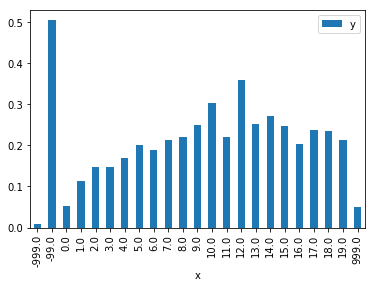

In [97]:
df = pd.DataFrame({"x": x, "y": y})
z = df.fillna(-999).groupby("x").mean()
plt = z.plot(kind="bar")

### Train Model

The first model fit will not use any constraints at all.

In [211]:
dtrain = xgb.DMatrix(x.reshape(-1, 1), label=y.reshape(-1, 1))
param = {
    "max_depth": 5,
    "eta":1,
    "silent":1,
    "objective":"binary:logistic"
}

In [212]:
bst = xgb.train(param, dtrain, num_boost_round=100)
yhat = bst.predict(dtrain)
preds = pd.DataFrame({'x': x, 'yhat': yhat})

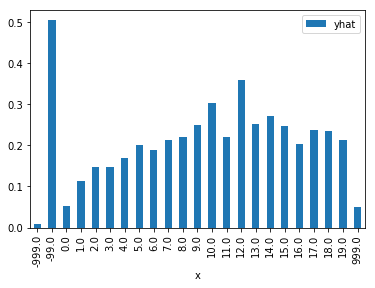

In [213]:
plt = preds.fillna(-999).groupby('x').mean().plot(kind='bar')

### Enforce Constraints

Regulations and repulational risk considerations demand that we treat certain levels of this variable in a special manner. Guidelines and experience recommend the following treatments:

| Value | Treatment |
|-------|-----------|
| Missing | Least points |
|-99 | Most Points |
|999 | Less than 0 to 20  |
|0 to 20 | Increasing Monotonicity |

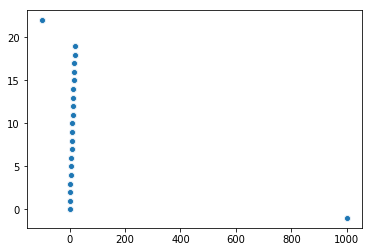

In [109]:
x_new = x.copy()

x_new[np.isnan(x)] = -2
x_new[x == 999] = -1
x_new[x == -99] = 22

sns.scatterplot(x, x_new)

In [110]:
dtrain = xgb.DMatrix(x_new.reshape(-1, 1), label=y.reshape(-1, 1))
param = {
    "max_depth": 5,
    "eta": 1,
    "silent": 1,
    "objective":"binary:logistic",
    "monotone_constraints": "(1)"    
}

In [111]:
bst2 = xgb.train(param, dtrain, num_boost_round=100)
yhat = bst2.predict(dtrain)
preds = pd.DataFrame({'x': x, 'yhat': yhat})

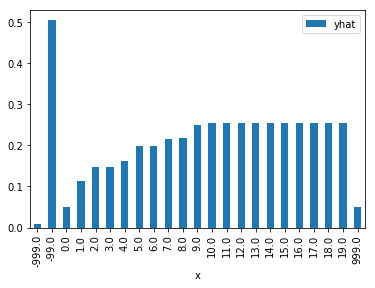

In [112]:
plt = preds.fillna(-999).groupby('x').mean().plot(kind='bar')

### More Complicated Constraints

Regulations and repulational risk considerations demand that we treat certain levels of this variable in a special manner. Guidelines and experience recommend the following treatments:

| Value | Treatment |
|-------|-----------|
| Missing | Least points |
|-99 | Most Points |
|999 | Less than 0 to 20  |
|0 to 10 | Increasing Monotonicity |
|11 to 20 | Decreasing Monotonicity |


In [154]:
x_inc1 = x.copy()

x_inc1[np.isnan(x)] = -3
x_inc1[x == 999] = -2
x_inc1[x == -99] = 12
x_inc1[x_inc1 > 10] = -1

x_inc2 = x_inc1.copy()
x_inc2[x_inc1 == -1] = 11

data = np.hstack([x_inc1.reshape(-1,1), x_inc2.reshape(-1,1)])
dtrain = xgb.DMatrix(data, label=y.reshape(-1, 1))
param = {
    "max_depth": 5,
    "eta": 1,
    "silent": 1,
    "objective":"binary:logistic",
    "monotone_constraints": "(1, 1)"
}

In [155]:
bst3 = xgb.train(param, dtrain, num_boost_round=100)
yhat = bst3.predict(dtrain)
preds = pd.DataFrame({'x': x, 'yhat': yhat})

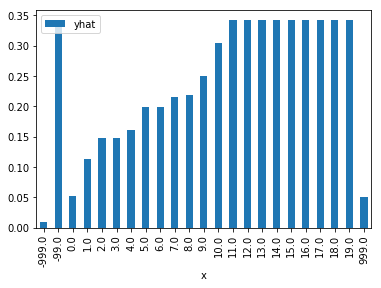

In [157]:
plt = preds.fillna(-999).groupby('x').mean().plot(kind='bar')

In [147]:
## repeat for decreasing mono
x_dec1 = x.copy()

x_dec1[np.isnan(x)] = 22
x_dec1[x == 999] = 21
x_dec1[x == -99] = -2
x_dec1[(x_dec1 >= 0) & (x_dec1 <= 10)] = -1

x_dec2 = x_dec1.copy()
x_dec2[x_dec2 == -1] = 20

In [160]:
data = np.hstack([
    x_inc1.reshape(-1,1), x_inc2.reshape(-1,1),
    x_dec1.reshape(-1,1), x_dec2.reshape(-1,1),
])

dtrain = xgb.DMatrix(data, label=y.reshape(-1, 1))
param = {
    "max_depth": 5,
    "eta": 1,
    "silent": 1,
    "objective": "binary:logistic",
    "monotone_constraints": "(1, 1, -1, -1)"
}

bst4 = xgb.train(param, dtrain, num_boost_round=100)
yhat = bst4.predict(dtrain)
preds = pd.DataFrame({'x': x, 'yhat': yhat})

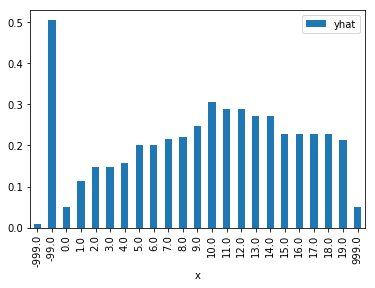

In [161]:
plt = preds.fillna(-999).groupby('x').mean().plot(kind='bar')

Notes: Each interval must place *other* intervals prior and subsequent to it's range for monotonic constraints. 

Need to investigate whether ALL other intervals can be collapsed into one value to effect this behavior.

### Check Results

Here we can programatically test whether the requested conditions are satisfied by checking the mean predictions for each value of `x`.

In [202]:
from collections import namedtuple

res = preds.fillna(-999).groupby('x').mean()

conds = namedtuple("Conditions", " ".join([f"cond{i}" for i in range(1,6)]))

# verify all conditions are met:
conds(
    np.all(res.yhat.loc[range(0,20)] > res.yhat.loc[999]),
    np.all(res.yhat.loc[range(0,20)] < res.yhat.loc[-99]),
    np.all(res.yhat >= res.yhat.loc[-999]),
    np.all(
        res.yhat.loc[range(0,10)][1:].reset_index(drop=True) >=
        res.yhat.loc[range(0,10)][:-1].reset_index(drop=True)),
    np.all(
        res.yhat.loc[range(11,20)][1:].reset_index(drop=True) <=
        res.yhat.loc[range(11,20)][:-1].reset_index(drop=True))
)

Conditions(cond1=True, cond2=True, cond3=True, cond4=True, cond5=True)

### Using the Results for Adverse Action

In [221]:
# TODO: conda doesn't have latest version of xgboost which can dump json
import xgboost
xgboost.__version__

'0.80'

In [220]:
bst4.dump_model("./mono_model.json", dump_format='json')

TypeError: dump_model() got an unexpected keyword argument 'dump_format'